# GP Initial Implementation: pyro

In [1]:
# Import needed libraries and modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Fetch dataset from UCI Repository
from ucimlrepo import fetch_ucirepo
heart_disease = fetch_ucirepo(id=45)
df = heart_disease.data.original

In [2]:
# Drop missing values
df = df.dropna()
df = df.reset_index(drop=True)

# Binarize data
df.loc[df['num'] != 0, 'num'] = 1

In [3]:
# Define features and target vectors
X = df.iloc[:,:-1].values
y = df['num'].values

In [4]:
# Import specifics
import torch
import pyro
import pyro.contrib.gp as gp

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

In [5]:
# Split train and test data
Test_Size = 0.2
Random_Seed = 82024

index = list(range(y.size))
train_index, test_index = train_test_split(index, test_size=Test_Size, random_state=Random_Seed)

train_df = df.loc[train_index]
test_df = df.loc[test_index]

In [6]:
# Create PyTorch tensors for X and y
train_X = torch.tensor(train_df.iloc[:,:-1].values)
train_y = torch.tensor(train_df['num'].values).double()

test_X = torch.tensor(test_df.iloc[:,:-1].values)
test_y = torch.tensor(test_df['num'].values).double()

In [7]:
# Create model
kernel = gp.kernels.RBF(input_dim=13)
pyro.clear_param_store()
likelihood = gp.likelihoods.Binary()
model = gp.models.VariationalGP(
    train_X,
    train_y,
    kernel,
    likelihood=likelihood,
    whiten=True,
    jitter=1e-03
)

In [8]:
# Train model
num_steps = 1000
loss = gp.util.train(model, num_steps=num_steps)

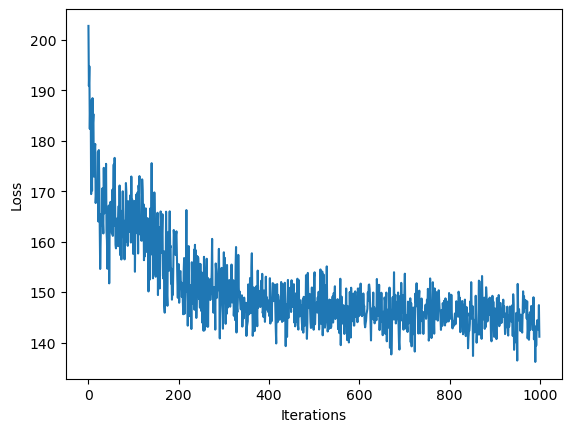

In [9]:
# Plot loss values
plt.plot(loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [10]:
# Test model
mean, var = model(test_X)
y_pred = model.likelihood(mean, var)
pred_preobs = y_pred.detach().numpy()

# Evaluation
acc = accuracy_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y.numpy(), pred_preobs)

print(f"Accuracy: {acc:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Accuracy: 0.65
ROC AUC: 0.64
